In [11]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import re

In [12]:
PROJECT_ROOT = Path.cwd().parent
OUTPUT_DIR = PROJECT_ROOT / "outputs"

SUMMARY_FILE = OUTPUT_DIR / "earnings_summaries.csv"

In [13]:
df = pd.read_csv(SUMMARY_FILE)
df.head(2)

,date,exchange,q,ticker,transcript,call_datetime,quarter_only,transcript_clean_basic,transcript_nlp,prepared_remarks,qna,prepared_len,qna_len,prepared_summary,qna_summary,api_called
0,"Nov 17, 2022, 5:00 p.m. ET",NYSE: GPS,2022-Q3,GPS,"Prepared Remarks:\nOperator\nGood afternoon, l...",2022-11-17 17:00:00,Q3,"Prepared Remarks:\nOperator\nGood afternoon, l...","Good afternoon, ladies and gentlemen. My name ...","Prepared Remarks:\nOperator\nGood afternoon, l...",Questions & Answers:\nOperator\n[Operator inst...,23689,34247,- Performance: Gap Inc.'s third quarter 2022 n...,- Management indicated that they are prepared ...,True
1,"Feb 10, 2021, 5:00 p.m. ET",NASDAQ: QLYS,2020-Q4,QLYS,Prepared Remarks:\nOperator\nLadies and gentle...,2021-02-10 17:00:00,Q4,Prepared Remarks:\nOperator\nLadies and gentle...,I will now turn the conference over to Mr. Vin...,Prepared Remarks:\nOperator\nLadies and gentle...,Questions and Answers:\nOperator\nThank you. [...,20191,35689,- Performance: Revenues for Q4 2020 grew 12% t...,- Customers are looking for solutions to help ...,True


In [14]:
# shape and columns appear correct 
print(df.shape)
print("\nColumns:")
print(df.columns.tolist())


(497, 16)

Columns:
['date', 'exchange', 'q', 'ticker', 'transcript', 'call_datetime', 'quarter_only', 'transcript_clean_basic', 'transcript_nlp', 'prepared_remarks', 'qna', 'prepared_len', 'qna_len', 'prepared_summary', 'qna_summary', 'api_called']


In [15]:
# all rows contian a summary 
summary_cols = ["prepared_summary", "qna_summary"]
missing_summary_counts = df[summary_cols].isna().sum()
print("Missing summaries:")
print(missing_summary_counts)

Missing summaries:
prepared_summary    0
qna_summary         0
dtype: int64


In [16]:
def char_count(text):
    if not isinstance(text, str):
        return 0
    return len(text)

In [17]:
df["prepared_summary_char_count"] = df["prepared_summary"].apply(char_count)
df["qna_summary_char_count"] = df["qna_summary"].apply(char_count)

In [18]:
#character len seem is higher than expected for 4-6 bullet points
df[[f"{c}_char_count" for c in summary_cols]].describe()

,prepared_summary_char_count,qna_summary_char_count
count,497.000000,497.000000
mean,2571.881288,3039.539235
std,894.225604,1280.557963
min,466.000000,83.000000
25%,1911.000000,2105.000000
50%,2554.000000,3028.000000
75%,3116.000000,3906.000000
max,5226.000000,9025.000000


In [19]:
def word_count(text):
    if not isinstance(text, str):
        return 0
    return len(text.split())

In [20]:
df["prepared_summary_word_count"] =    df["prepared_summary"].apply(word_count)
df["qna_summary_word_count"] = df["qna_summary"].apply(word_count)

Summaries are too verbose compared to expctation from the prompt

In [21]:

df[[f"{c}_word_count" for c in summary_cols]].describe()

,prepared_summary_word_count,qna_summary_word_count
count,497.000000,497.000000
mean,383.388330,461.847082
std,132.361035,192.972265
min,63.000000,15.000000
25%,287.000000,325.000000
50%,375.000000,457.000000
75%,459.000000,591.000000
max,755.000000,1355.000000


In [23]:
def sentence_count(text):
    if not isinstance(text, str):
        return 0
    return len(re.findall(r"[.!?]+", text))

df["prepared_summary_sentence_count"] = df["prepared_summary"].apply(sentence_count)
df["qna_summary_sentence_count"] = df["qna_summary"].apply(sentence_count)


Appear to be lacking conciseness in the summaries. Over 40 'sentences' in some cases and some with 0 which based on other metrics may be a punctuation issue

In [24]:
df[[f"{c}_sentence_count" for c in summary_cols]].describe()

,prepared_summary_sentence_count,qna_summary_sentence_count
count,497.000000,497.000000
mean,18.680080,17.253521
std,8.511393,8.362027
min,0.000000,0.000000
25%,12.000000,11.000000
50%,18.000000,16.000000
75%,24.000000,22.000000
max,46.000000,50.000000


In [25]:
#review summaries with zero sentences
zero_sentence = df[(df['prepared_summary_sentence_count'] == 0) | (df['qna_summary_sentence_count'] == 0)]

In [26]:
# zero sentence summaries have significant word counts (missing punctuation)
zero_sentence[['prepared_summary_sentence_count', 'prepared_summary_word_count', 'qna_summary_sentence_count',  'qna_summary_word_count']]

,prepared_summary_sentence_count,prepared_summary_word_count,qna_summary_sentence_count,qna_summary_word_count
1,12,172,0,102
6,0,251,6,155
14,14,197,0,80
55,0,88,20,663
123,0,251,30,655


In [28]:
pd.set_option('display.max_colwidth', None)
zero_sentence.loc[zero_sentence['prepared_summary_sentence_count'] == 0][['ticker', 'prepared_summary']]

,ticker,prepared_summary
6,COIN,"- Performance:\n- Solid quarter despite volatility in the crypto market\n- Accelerating pace of global crypto adoption, mirroring the early days of the internet\n- Retail transaction fees influenced by volatility, rebounding in October\n- Subscription and services revenue growth despite volatility in transaction revenue\n- Guidance:\n- Strong start to Q4 with increased monthly transacting users and trading volume in October\n- Increased MTU scenarios for full year 2021, with updated outlook reflecting strengthening view of Q4\n- Transaction expenses expected to be in the mid-teens as a percent of revenue\n- Sales and marketing expenditures to increase as brand investments ramp up\n- Strategic changes:\n- Launch of Coinbase NFT platform in the next quarter or two as part of new initiatives\n- Focus on becoming a ""crypto native"" platform, offering diverse assets and features\n- Coinbase Tax Center rolled out to help users track cost basis and profitability for tax purposes\n- International expansion plans include deepening product capabilities across different geographies\n- Coinbase's competitive strength lies in being a regulated, trustworthy player with crypto-native features\n- Continued focus on diversified revenue streams through new products and services\n- Update on recent launches in Japan and Germany, with plans to offer similar products as in the US\n- Collaborating with regulators to shape regulatory framework for the industry\n- Marketing strategy evolving to reach a billion crypto users globally, with emphasis on brand efforts\n\n- Risks:\n- Competition from both traditional financial institutions and other crypto-native companies"
55,CRUS,"- Record revenue and earnings per share in the second quarter, with 34% year-over-year revenue growth\n- Progress made in diversifying beyond audio, achieving milestones in high-performance mixed-signal products\n- Excitement about new technologies such as camera controllers, power conversion ICs, and fast-charging products\n- High-performance mixed-signal business now accounts for 30% of total revenue, up 117% from a year ago\n- CFO retiring after 21 years of service, search for successor underway\n- Addition of Raghib Hussain to the Board of Directors, bringing valuable semiconductor industry expertise"
123,MTCH,"- Performance:\n- Total revenue growth accelerated to 23% year-over-year, driven by strong performance of Tinder and non-Tinder brands\n- Direct revenue from non-Tinder brands grew by 30%, the highest since IPO in 2015\n- Guidance:\n- Plans for the pending Hyperconnect acquisition and post-closing integration are progressing, aiming to close by end of Q2\n- Focus on innovation and expanding outcomes for users, with plans to enhance user guidance program for successful dates\n- Risks:\n- Uncertainty due to ongoing pandemic situations in countries like India, Brazil, and Japan, impacting global operations\n- Acknowledgment of growing trend of isolation and loneliness affecting mental health, highlighting the need for meaningful connections\n- Strategic Changes:\n- Transformation of Tinder experience from swipe match message funnel to a multi-dimensional and ritual experience, with focus on increased engagement and monetization\n- Expansion of services into social discovery categories through the pending Hyperconnect acquisition, leveraging video and AI technology for meaningful connections\n- Non-Tinder brands saw significant subscriber growth, with ARPU up 9% year-over-year\n- Operating income and EBITDA grew significantly, with EBITDA margins increasing to 34%\n- Total revenue for Q2 expected to increase by 22-24% year-over-year, with strong growth expected at both Tinder and non-Tinder brands\n- Increased sales and marketing spend expected in Q2 compared to the prior year\n- Risks include uneven recovery due to slower vaccine roll-outs and higher case counts in many markets\n- Strategic changes include the acquisition of Hyperconnec

In [29]:
pd.set_option('display.max_colwidth', None)
zero_sentence.loc[zero_sentence['qna_summary_sentence_count'] == 0][['ticker', 'qna_summary']]

,ticker,qna_summary
1,QLYS,"- Customers are looking for solutions to help them detect cybersecurity issues quickly and respond effectively in light of recent attacks\n- Qualys' platform, focusing on risk mitigation, threat detection, and response capabilities, is well-positioned to meet customer needs\n- Adoption of Qualys' VMDR solution is driving the adoption of additional services within existing customers\n- Guidance for the year anticipates 10-11% growth, with a focus on current bookings and pipeline visibility\n- Key hires have been made in sales, marketing, and product to drive revenue expansion and accelerate growth, with plans to hire a Chief Revenue Officer to lead these efforts"
14,WOR,"- Management expects inventory holding gains to be lower in Q1 compared to Q4 but still significant\n- Worthington is well-positioned to manage inventory risk and potential steel price inflection\n- Additional gains from derivative activities are separate from inventory holding gains\n- Pressure Cylinder business saw robust margins in Q4 due to cost recovery, disposal of underperforming operations, and innovation efforts\n- Sustainability of margins in the Pressure Cylinder business is supported by product innovation and cost recovery efforts"


In [30]:

def bullet_count(text):
    if not isinstance(text, str):
        return 0

    count = 0
    for line in text.splitlines():
        line_clean = line.strip().lower()
        if line_clean.startswith("-"):
            count += 1
    return count


In [31]:
df["prepared_summary_bullet_count"] = df["prepared_summary"].apply(bullet_count)
df["qna_summary_bullet_count"] = df["qna_summary"].apply(bullet_count)

Prompt was for 4-6 bullet points per summary - will need to deduplicate or more precise prompts

In [32]:
df[[f"{c}_bullet_count" for c in summary_cols]].describe()

,prepared_summary_bullet_count,qna_summary_bullet_count
count,497.000000,497.000000
mean,16.060362,18.937626
std,7.458783,7.653413
min,4.000000,0.000000
25%,12.000000,14.000000
50%,14.000000,19.000000
75%,21.000000,24.000000
max,48.000000,55.000000


In [33]:
#prepared summary expectaion was the below sections
EXPECTED_SECTIONS = [
    "Performance",
    "Guidance",
    "Risks",
    "Strategic changes"
]

In [34]:
def section_header_count(text):
    if not isinstance(text, str):
        return 0

    count = 0
    for line in text.splitlines():
        line_clean = line.strip()
        for section in EXPECTED_SECTIONS:
            if (f"{section}") in line_clean:
                count += 1
    return count

In [35]:
df["prepared_summary_section_count"] = df["prepared_summary"].apply(section_header_count)

Appears it is repeating the sections multiple times in most prepared summaries

In [36]:
df['prepared_summary_section_count'].describe()

count    497.000000
mean       9.376258
std        3.749903
min        0.000000
25%        8.000000
50%        8.000000
75%       12.000000
max       24.000000
Name: prepared_summary_section_count, dtype: float64

Compression Ratios

In [37]:
# originalword count
df["prepared_word_count"] = df["prepared_remarks"].apply(word_count)
# compression ratio (summary / original)
df["prepared_word_compression"] = (df["prepared_summary_word_count"] / df["prepared_word_count"])

In [38]:
# originalword count
df["prepared_word_count"] = df["prepared_remarks"].apply(word_count)
# compression ratio (summary / original)
df["prepared_word_compression"] = (df["prepared_summary_word_count"] / df["prepared_word_count"])

In [39]:
df['prepared_word_compression'].describe()

count    497.000000
mean       0.125007
std        0.027726
min        0.035766
25%        0.109740
50%        0.124100
75%        0.140345
max        0.346154
Name: prepared_word_compression, dtype: float64

Prepared remarks summarization, with an average compression ratio of 12.5% is higher than desired ratio of 5-10%

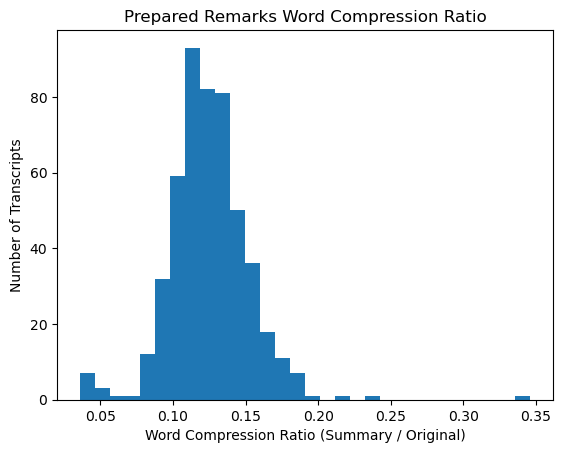

In [40]:
plt.figure()
plt.hist(df["prepared_word_compression"], bins=30)
plt.xlabel("Word Compression Ratio (Summary / Original)")
plt.ylabel("Number of Transcripts")
plt.title("Prepared Remarks Word Compression Ratio")
plt.show()

In [41]:
# original char count
df["prepared_char_count"] = df["prepared_remarks"].apply(char_count)
# compression ratio (summary / original)
df["prepared_char_compression"] = (df["prepared_summary_char_count"] / df["prepared_char_count"])
df['prepared_char_compression'].describe()

count    497.000000
mean       0.134162
std        0.028362
min        0.038480
25%        0.117965
50%        0.132216
75%        0.149655
max        0.356815
Name: prepared_char_compression, dtype: float64

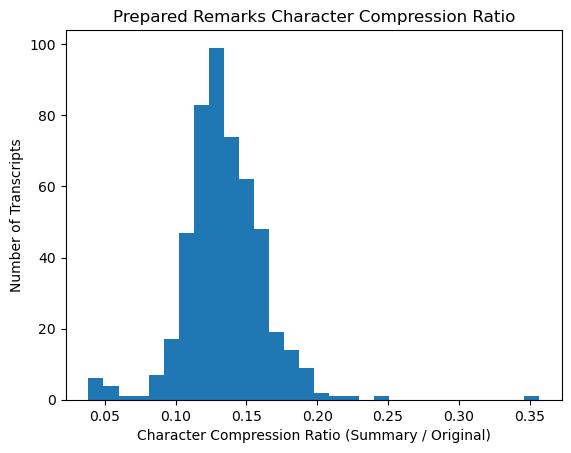

In [42]:
plt.figure()
plt.hist(df["prepared_char_compression"], bins=30)
plt.xlabel("Character Compression Ratio (Summary / Original)")
plt.ylabel("Number of Transcripts")
plt.title("Prepared Remarks Character Compression Ratio")
plt.show()

In [43]:
df["qna_word_count"] = df["qna"].apply(word_count)
df["qna_word_compression"] = (df["qna_summary_word_count"] / df["qna_word_count"])
# outliers need to investigate
df['qna_word_compression'].describe()

count    497.000000
mean       0.105409
std        0.137698
min        0.001572
25%        0.088712
50%        0.096224
75%        0.105282
max        3.034483
Name: qna_word_compression, dtype: float64

In [44]:
outliers = df.loc[df["qna_word_compression"] > 0.5, ["ticker", "date", "qna_word_compression", "qna"]]
outliers = outliers.sort_values(by="qna_word_compression", ascending=False)

There was no Q & A on the outliers

In [45]:
print(df.loc[257, "qna"]), print(df.loc[484, "qna"])

Questions and Answers:
Duration: 16 minutes
Call participants:
Michael Combs -- President and Chief Executive Officer
Brandon O'Brien -- Chief Financial Officer
More CRVL analysis
All earnings call transcripts





Questions and Answers:
Operator
We will now begin the question-and-answer session. [Operator Instructions] Showing no questions. This concludes our question-and-answer session and conference call. [Operator Closing Remarks]
Duration: 18 minutes
Call participants:
Michael Stein -- Chief Executive Officer of Genie Energy; Chief Executive Officer of Genie Retail Energy
Avi Goldin -- Chief Financial Officer
More GNE analysis
All earnings call transcripts







(None, None)

In [46]:
# windsorize to visualize
from scipy.stats.mstats import winsorize

df["qna_word_compression_w"] = winsorize(
    df["qna_word_compression"],
    limits=[0.01, 0.01]
)

Q&A summarization, with an average compression ratio of 10% i better than the prepared remarks but on hte high end of expectations.A few transcripts were anomolous due to no questions on the caLL

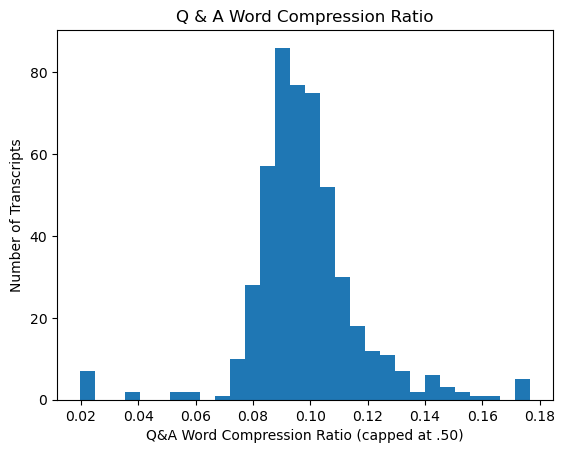

In [47]:
plt.figure()
plt.hist(df["qna_word_compression_w"], bins=30) # remove outliers
plt.xlabel("Q&A Word Compression Ratio (capped at .50)")
plt.ylabel("Number of Transcripts")
plt.title("Q & A Word Compression Ratio")
plt.show()

In [48]:
df["qna_char_count"] = df["qna"].apply(char_count)
df["qna_char_compression"] = (df["qna_summary_char_count"] / df["qna_char_count"])

df['qna_char_compression'].describe()

count    497.000000
mean       0.120129
std        0.134208
min        0.001568
25%        0.102905
50%        0.111542
75%        0.123103
max        3.009346
Name: qna_char_compression, dtype: float64

In [49]:
df["qna_char_compression_w"] = winsorize(
    df["qna_char_compression"],
    limits=[0.01, 0.01]
)

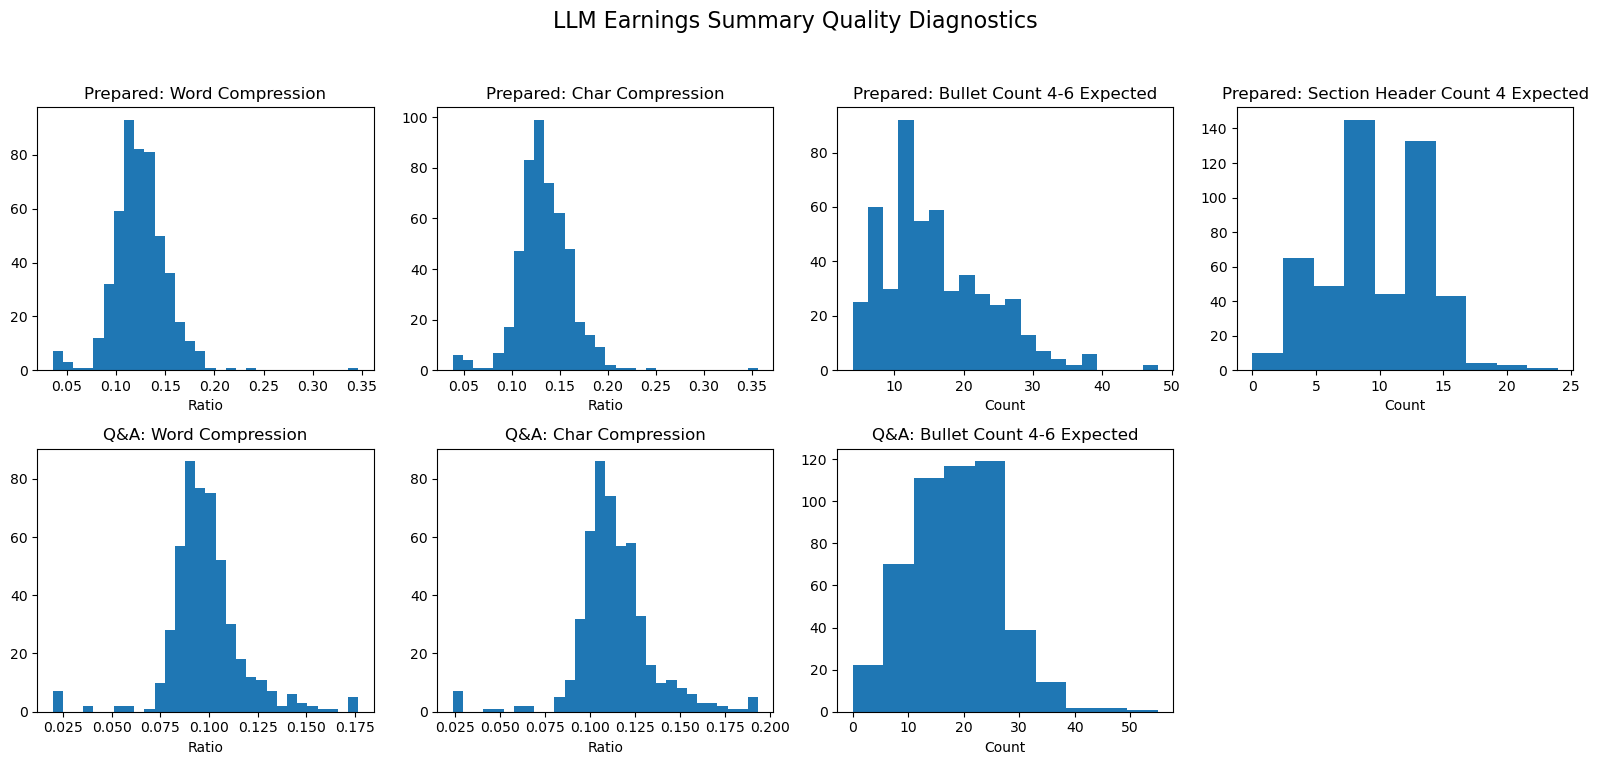

In [50]:
METRICS_FILE = OUTPUT_DIR / "summary_quality_diagnostics.png"
fig, axs = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle("LLM Earnings Summary Quality Diagnostics", fontsize=16)

# Prepared summaries (row 0)
axs[0, 0].hist(df["prepared_word_compression"], bins=30)
axs[0, 0].set_title("Prepared: Word Compression")
axs[0, 0].set_xlabel("Ratio")

axs[0, 1].hist(df["prepared_char_compression"], bins=30)
axs[0, 1].set_title("Prepared: Char Compression")
axs[0, 1].set_xlabel("Ratio")

axs[0, 2].hist(df["prepared_summary_bullet_count"], bins=20)
axs[0, 2].set_title("Prepared: Bullet Count 4-6 Expected")
axs[0, 2].set_xlabel("Count")

axs[0, 3].hist(df["prepared_summary_section_count"], bins=10)
axs[0, 3].set_title("Prepared: Section Header Count 4 Expected")
axs[0, 3].set_xlabel("Count")

# Q&A summaries (row 1)
axs[1, 0].hist(df["qna_word_compression_w"], bins=30)
axs[1, 0].set_title("Q&A: Word Compression")
axs[1, 0].set_xlabel("Ratio")

axs[1, 1].hist(df["qna_char_compression_w"], bins=30)
axs[1, 1].set_title("Q&A: Char Compression")
axs[1, 1].set_xlabel("Ratio")

axs[1, 2].hist(df["qna_summary_bullet_count"], bins=10)
axs[1, 2].set_title("Q&A: Bullet Count 4-6 Expected")
axs[1, 2].set_xlabel("Count")

# Optional: leave last Q&A chart empty or add another metric later
axs[1, 3].axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(METRICS_FILE, dpi=150)
plt.show()


In [115]:
EXPECTED_SECTIONS = [
    "Performance",
    "Guidance",
    "Risks",
    "Strategic changes"
]
PREPARED_BULLET_RANGE = (4, 6)
QNA_BULLET_RANGE = (3, 5)

COMPRESSION_RANGE = (0.05, 0.15)

In [116]:
def section_adherence(text, expected_sections):
    """Return 1 if criteria met, else 0"""
    if not isinstance(text, str):
        return 0
    counts = [text.count(f"{s}:") for s in expected_sections]
    return int(all(c == 1 for c in counts))

def bullet_adherence(count, bullet_range):
    """Return 1 if count is within range, else 0"""
    if not isinstance(count, (int, float)):
        return 0
    return int(bullet_range[0] <= count <= bullet_range[1])
def compression_adherence(ratio, compression_range):
    """Checks expected compression ratio is in range"""
    if not isinstance(ratio, (int, float)):
        return 0
    return int(compression_range[0] <= ratio <= compression_range[1])

In [117]:
df['prepared_summary_section_adherence'] = df.apply(lambda x: section_adherence(x['prepared_summary'], EXPECTED_SECTIONS), axis=1)
df['prepared_bullet_adherence'] = df.apply(lambda x: bullet_adherence(x['prepared_summary_bullet_count'], PREPARED_BULLET_RANGE), axis=1)
df['prepared_comp_ratio_adherence'] = df.apply(lambda x: compression_adherence(x['prepared_word_compression'], COMPRESSION_RANGE), axis=1)

# Total Adherece score
df['prepared_summary_adherence_score'] = (
    (df['prepared_summary_section_adherence'] == 1) & 
    (df['prepared_bullet_adherence'] == 1) & 
    (df['prepared_comp_ratio_adherence'] == 1)
).astype(int)

In [118]:
df['qna_bullet_adherence'] = df.apply(lambda x: bullet_adherence(x['qna_summary_bullet_count'], PREPARED_BULLET_RANGE), axis=1)
df['qna_comp_ratio_adherence'] = df.apply(lambda x: compression_adherence(x['qna_word_compression'], COMPRESSION_RANGE), axis=1)

# Total Adherece sccor
df['qna_summary_adherence_score'] = (
    (df['qna_bullet_adherence'] == 1) & 
    (df['qna_comp_ratio_adherence'] == 1)
).astype(int)

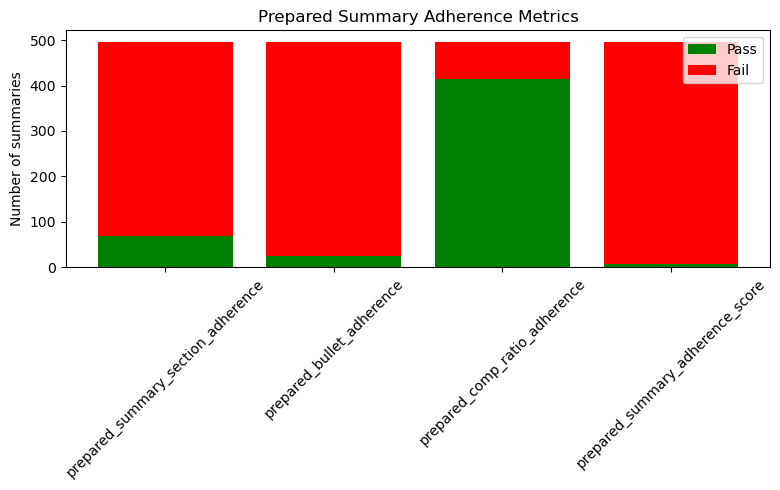

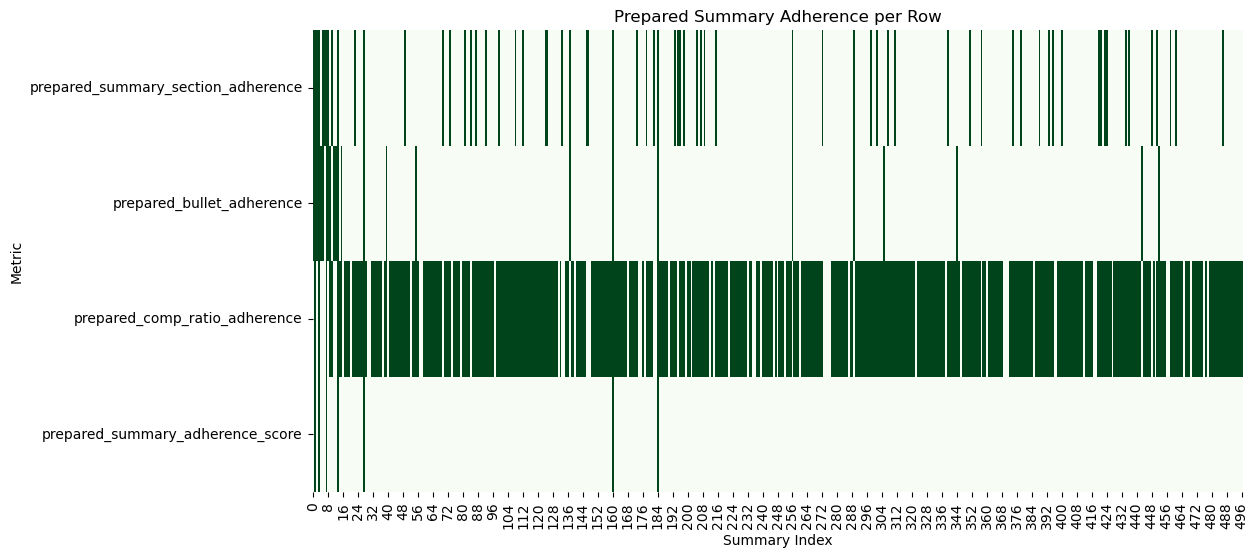

In [119]:
metrics_prepared = ['prepared_summary_section_adherence', 
                    'prepared_bullet_adherence', 
                    'prepared_comp_ratio_adherence', 
                    'prepared_summary_adherence_score']

# 1. Bar chart: counts of passing/failing per metric
fig, ax = plt.subplots(figsize=(8,5))
pass_counts = [df[m].sum() for m in metrics_prepared]
fail_counts = [len(df) - c for c in pass_counts]

ax.bar(metrics_prepared, pass_counts, label='Pass', color='green')
ax.bar(metrics_prepared, fail_counts, bottom=pass_counts, label='Fail', color='red')
ax.set_ylabel('Number of summaries')
ax.set_title('Prepared Summary Adherence Metrics')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 2. Optional heatmap: adherence per row (0=fail,1=pass)
import seaborn as sns

plt.figure(figsize=(12,6))
sns.heatmap(df[metrics_prepared].T, cmap='Greens', cbar=False)
plt.title('Prepared Summary Adherence per Row')
plt.xlabel('Summary Index')
plt.ylabel('Metric')
plt.show()


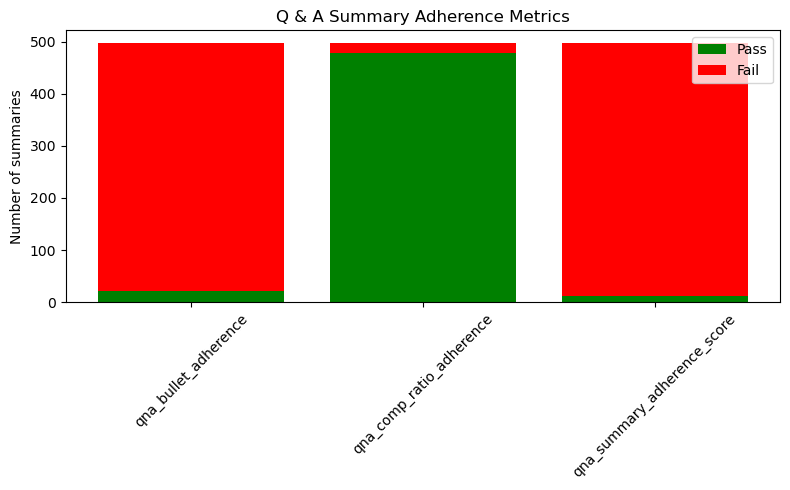

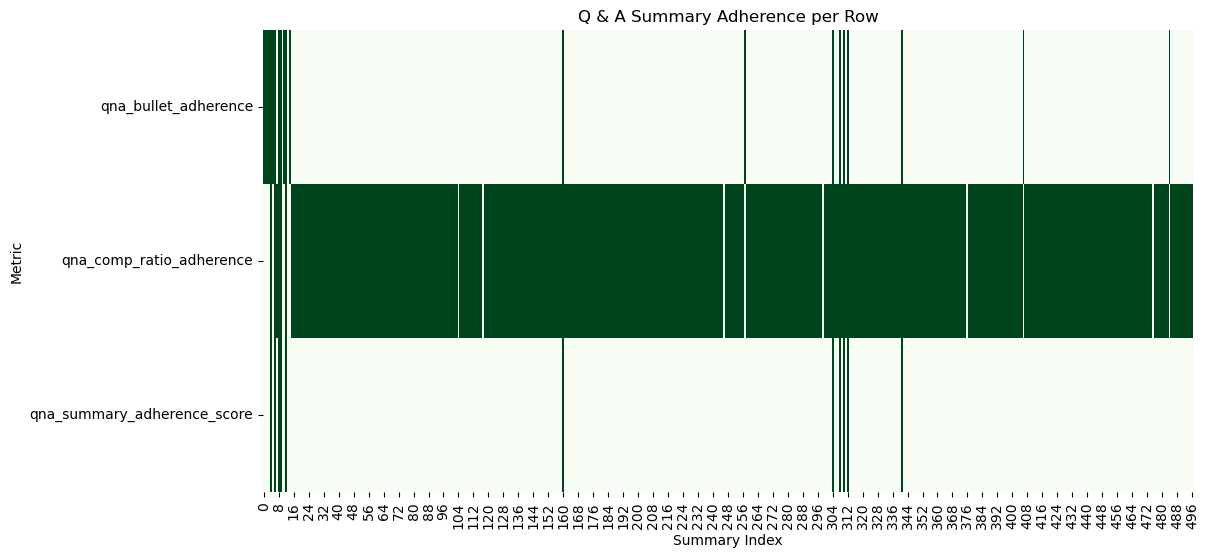

In [120]:
metrics_qna = ['qna_bullet_adherence', 
                    'qna_comp_ratio_adherence', 
                    'qna_summary_adherence_score']

# 1. Bar chart: counts of passing/failing per metric
fig, ax = plt.subplots(figsize=(8,5))
pass_counts = [df[m].sum() for m in metrics_qna]
fail_counts = [len(df) - c for c in pass_counts]

ax.bar(metrics_qna, pass_counts, label='Pass', color='green')
ax.bar(metrics_qna, fail_counts, bottom=pass_counts, label='Fail', color='red')
ax.set_ylabel('Number of summaries')
ax.set_title('Q & A Summary Adherence Metrics')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


import seaborn as sns

plt.figure(figsize=(12,6))
sns.heatmap(df[metrics_qna].T, cmap='Greens', cbar=False)
plt.title('Q & A Summary Adherence per Row')
plt.xlabel('Summary Index')
plt.ylabel('Metric')
plt.show()
